
## **Predicting Home Credit Default Risk (Capstone Project)**


### **Introduction**

Many people struggle to get loans due to insufficient or non-existent credit histories. Home Credit strive to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. 

The goal of this project is to build a machine learning model that will predict clients' repayment abilities to ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.


#### **Exploratory Data Analysis**





In [19]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import math
from sklearn.model_selection import cross_val_score, KFold, cross_validate, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

sns.set_palette("Set1")

In [21]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [22]:
train_df= pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/application_train.csv')

test = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/application_test.csv')

In [23]:
train_df.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
train_df.shape, test.shape

((307511, 122), (48744, 121))

The train set has 122 variables and 307511 observations, while the test set has 48744 observations with 121 variables. This dataset has a lot of samples to train on

In [25]:
train_num= train_df.select_dtypes(exclude=['object']).drop('SK_ID_CURR', axis= 1)
train_df_numeric= train_num.copy()

train_cat= train_df.select_dtypes(include=['object'])
train_df_cat= train_cat.copy()

print('The train set has', train_df_numeric.shape[1], 'numeric variables and', train_df_cat.shape[1], 'categorical variables')

The train set has 105 numeric variables and 16 categorical variables


### **Checking for missing values**

67 variables contain missing values


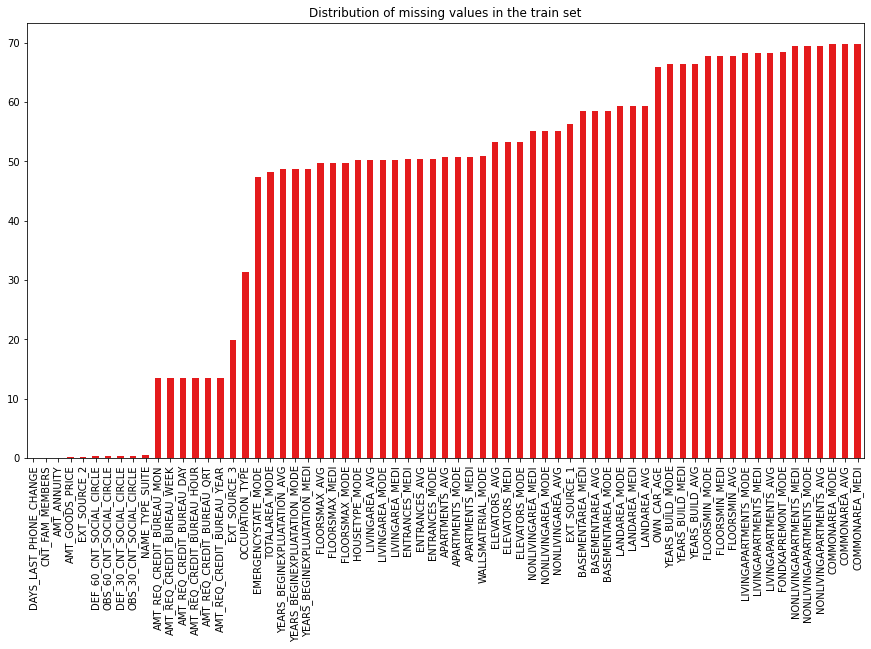

In [26]:
# Missing values
f = plt.figure(figsize=(15, 8));
missing_values = train_df.isnull().sum()/len(train_df) * 100
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)
missing_values.plot.bar();
plt.title('Distribution of missing values in the train set')
print(missing_values.count(), 'variables contain missing values')

The dataset contains a lot of missing values. Majority of these missing values are concentrated in the apartment-based features which suggests that there is no information on where some of the clients lived. Hence these will be filled with zero. The same goes for features representing the number of enquiries made to the Bureau before the application.

In addition, there is a pattern to the missingness as features representing a certain characteristics have same number of missing values, hence they will be imputed in the same manner.


##### **Target Variable**

In [27]:
non_defaulters= round(train_df.TARGET.value_counts()[0]/len(train_df.TARGET) * 100, 1)
defaulters= round(train_df.TARGET.value_counts()[1]/len(train_df.TARGET) * 100, 1)
print('Percentage of defaulters: ', defaulters, '%')
print('Percentage of non-defaulters: ', non_defaulters, '%')

Percentage of defaulters:  8.1 %
Percentage of non-defaulters:  91.9 %


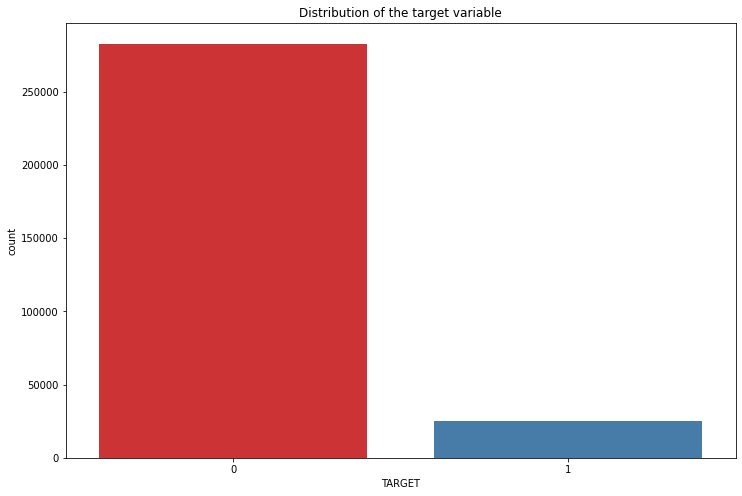

In [28]:
fig= plt.figure(figsize=(12, 8));
sns.countplot(train_df['TARGET'])
plt.title('Distribution of the target variable');

Most of the clients (91.9%) repaid their loans while 8.1% were defaulters. This implies that the target variable is imbalanced, which requires a proper crossvalidation strategy for good model evaluation.



### **Numeric Variables**

Some of the numeric features are time-based (in days) and are negatives values. These needs to be transformed to make meaning of their distribution.

In [29]:
def convert_days(days_negative):
    days_positive = -1 * days_negative
    year_positive= days_positive/365
    year_positive= math.ceil(year_positive)
    return year_positive

train_df_numeric['YEARS_BIRTH'] = train_df_numeric['DAYS_BIRTH'].apply(convert_days)
train_df_numeric['YEARS_EMPLOYED'] = train_df_numeric['DAYS_EMPLOYED'].apply(convert_days)
train_df_numeric['YEARS_REGISTRATION'] = train_df_numeric['DAYS_REGISTRATION'].apply(convert_days)
train_df_numeric['YEARS_ID_PUBLISH'] = train_df_numeric['DAYS_ID_PUBLISH'].apply(convert_days)
train_df_numeric.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH'], axis= 1, inplace=True)

Text(0.5, 0.98, 'Distribution of some selected features')

<Figure size 1080x720 with 0 Axes>

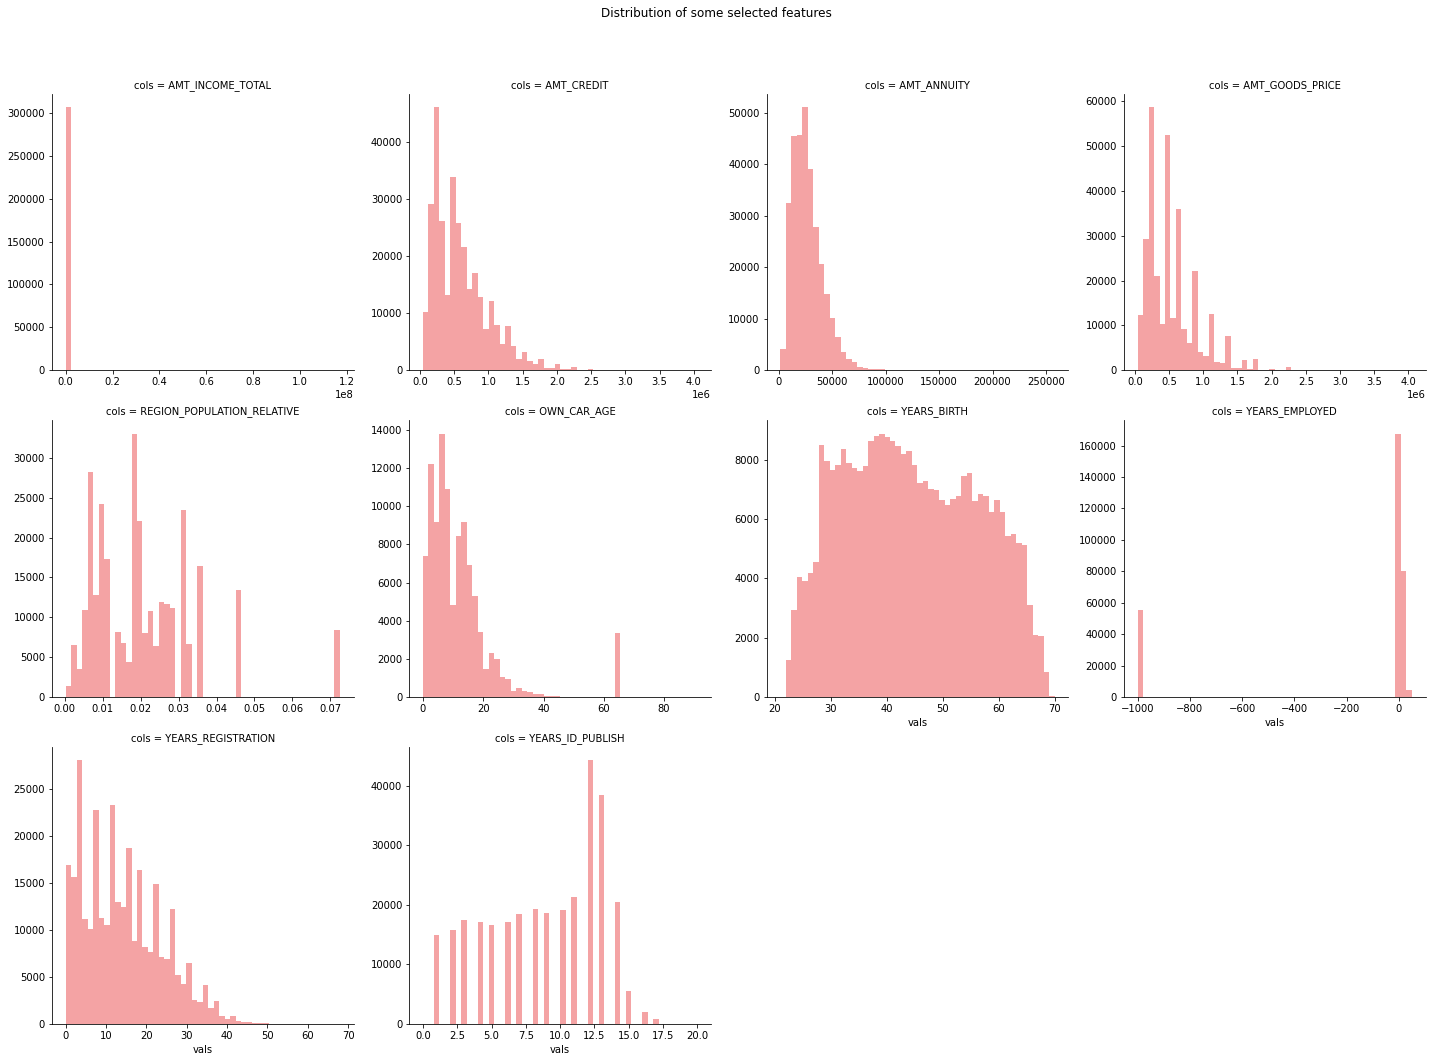

In [30]:
fig = plt.figure(figsize=(15, 10))
num_cols= ['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE','OWN_CAR_AGE',
           'YEARS_BIRTH', 'YEARS_EMPLOYED', 'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH']
f = train_df_numeric[num_cols].melt(['TARGET'], var_name='cols',  value_name='vals')
g = sns.FacetGrid(f, col='cols', col_wrap=4, sharex=False, sharey=False, height=5);
g = (g.map(sns.distplot, "vals", kde=False));
plt.ticklabel_format(axis="both", style="plain")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution of some selected features')

In [31]:
train_df_numeric.YEARS_BIRTH.describe()

count    307511.000000
mean         44.433090
std          11.954493
min          21.000000
25%          35.000000
50%          44.000000
75%          54.000000
max          70.000000
Name: YEARS_BIRTH, dtype: float64

The distribution of income earned by the clients is skewed, which is not surprising, as well as the credit amount of the loan and loan annuity.

The age of client is normally distributed, with a typical client being 44 years old on the average.

Some errors are noticeable on the YEARS_EMPLOYED feature (-1000), which implies that a client has been employed for 1000 years. These erroenous values would be addressed.

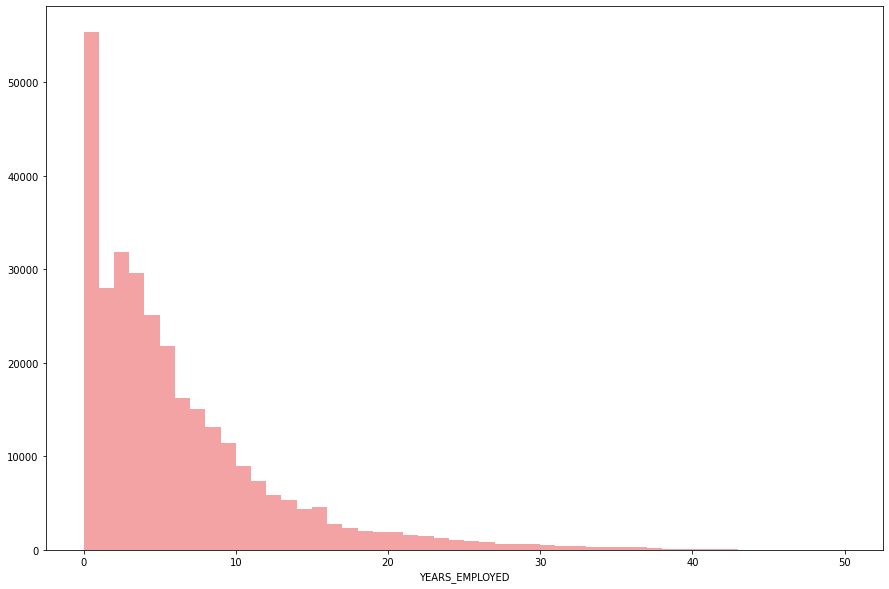

In [32]:
train_df_numeric['YEARS_EMPLOYED'][train_df_numeric['YEARS_EMPLOYED'] == -1000] = 0

fig = plt.figure(figsize=(15, 10))
sns.distplot(train_df_numeric['YEARS_EMPLOYED'], kde= False)
plt.ticklabel_format(axis="both", style="plain")

Now, it can be obseved that most of the clients have been working between 0-10 years.

<Figure size 1080x720 with 0 Axes>

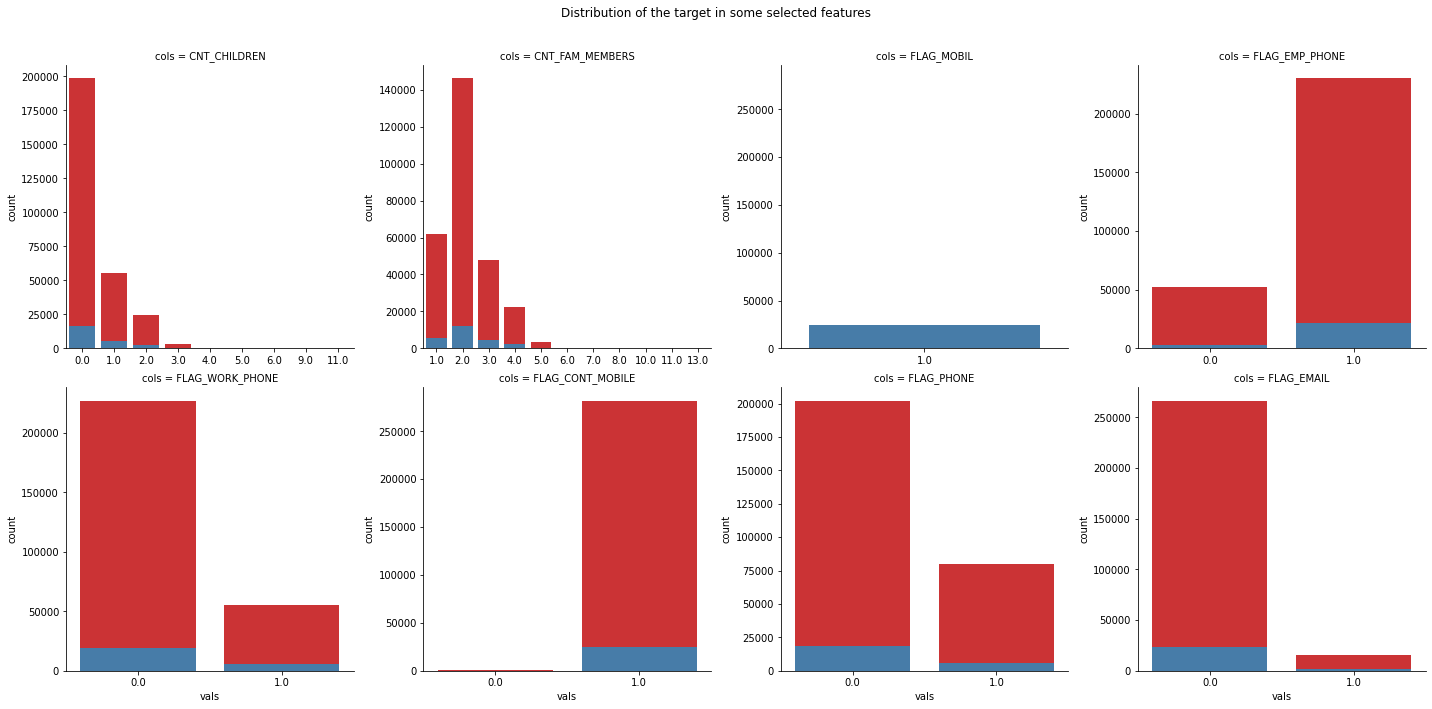

In [33]:
fig = plt.figure(figsize=(15, 10))
num_cols= ['TARGET', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'FLAG_MOBIL','FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL']
f = train_df_numeric[num_cols].melt(['TARGET'], var_name='cols',  value_name='vals')
g = sns.FacetGrid(f, col='cols', col_wrap=4, sharex=False, sharey=False, height=5, hue= 'TARGET');
g = (g.map(sns.countplot, "vals"));
g.fig.subplots_adjust(top=0.9);
g.fig.suptitle('Distribution of the target in some selected features');

Most of the defaulters had no children, did not provide work phone, or email address and could not be reached on their mobile phones. This brings curiousity to the age distribution of the clients across the target variable.

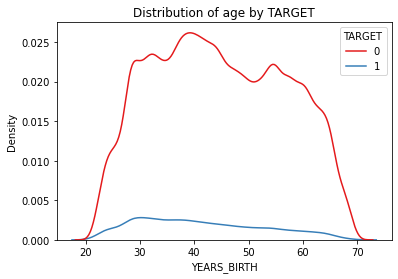

In [34]:
sns.kdeplot(data= train_df_numeric, x='YEARS_BIRTH', hue= 'TARGET')
plt.title('Distribution of age by TARGET');

A typical defaulter is in their early forties.

In [35]:
train_df_numeric.corr()['TARGET'].abs().sort_values(ascending=False)

TARGET                          1.000000
EXT_SOURCE_3                    0.178919
EXT_SOURCE_2                    0.160472
EXT_SOURCE_1                    0.155317
YEARS_BIRTH                     0.078237
REGION_RATING_CLIENT_W_CITY     0.060893
REGION_RATING_CLIENT            0.058899
DAYS_LAST_PHONE_CHANGE          0.055218
YEARS_ID_PUBLISH                0.051132
REG_CITY_NOT_WORK_CITY          0.050994
FLAG_EMP_PHONE                  0.045982
REG_CITY_NOT_LIVE_CITY          0.044395
FLAG_DOCUMENT_3                 0.044346
FLOORSMAX_AVG                   0.044003
YEARS_EMPLOYED                  0.043954
FLOORSMAX_MEDI                  0.043768
FLOORSMAX_MODE                  0.043226
YEARS_REGISTRATION              0.041971
AMT_GOODS_PRICE                 0.039645
OWN_CAR_AGE                     0.037612
REGION_POPULATION_RELATIVE      0.037227
ELEVATORS_AVG                   0.034199
ELEVATORS_MEDI                  0.033863
FLOORSMIN_AVG                   0.033614
FLOORSMIN_MEDI  

Text(0.5, 1.0, 'Correlation of continuous features with target')

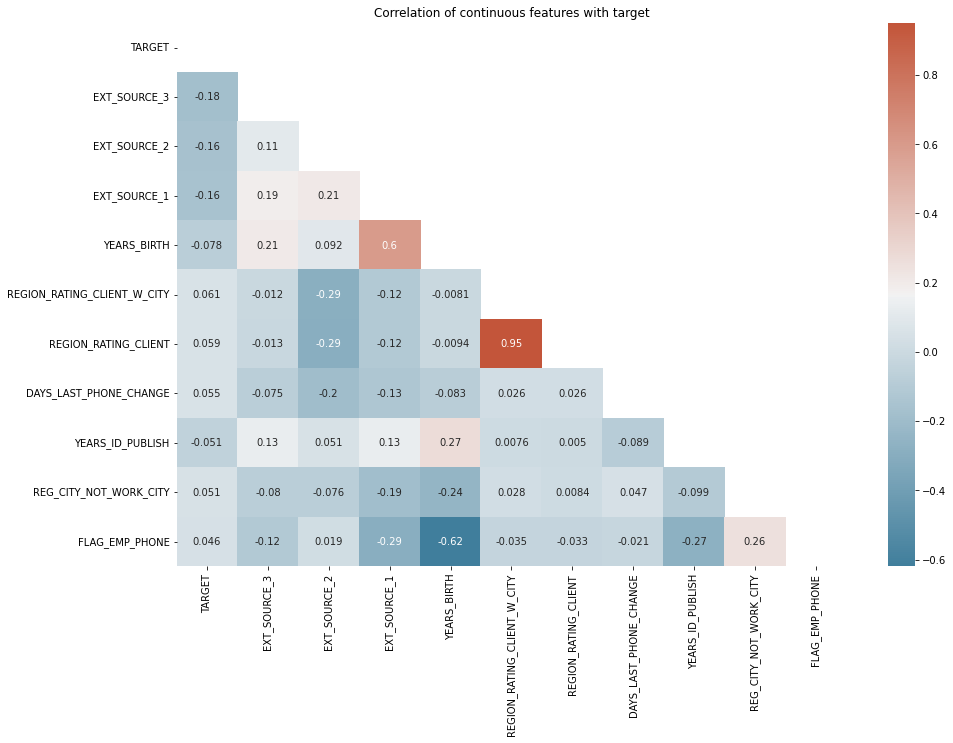

In [36]:
# Checking for multicollinearity among the first 10 features wih higher correlation coefficients
f = plt.figure(figsize=(15, 10))
cols= ['TARGET', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'YEARS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT',
       'DAYS_LAST_PHONE_CHANGE', 'YEARS_ID_PUBLISH', 'REG_CITY_NOT_WORK_CITY', 'FLAG_EMP_PHONE']
corr = train_df_numeric[cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, mask=mask, annot= True);
plt.title('Correlation of continuous features with target')

REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY are higly correlated.

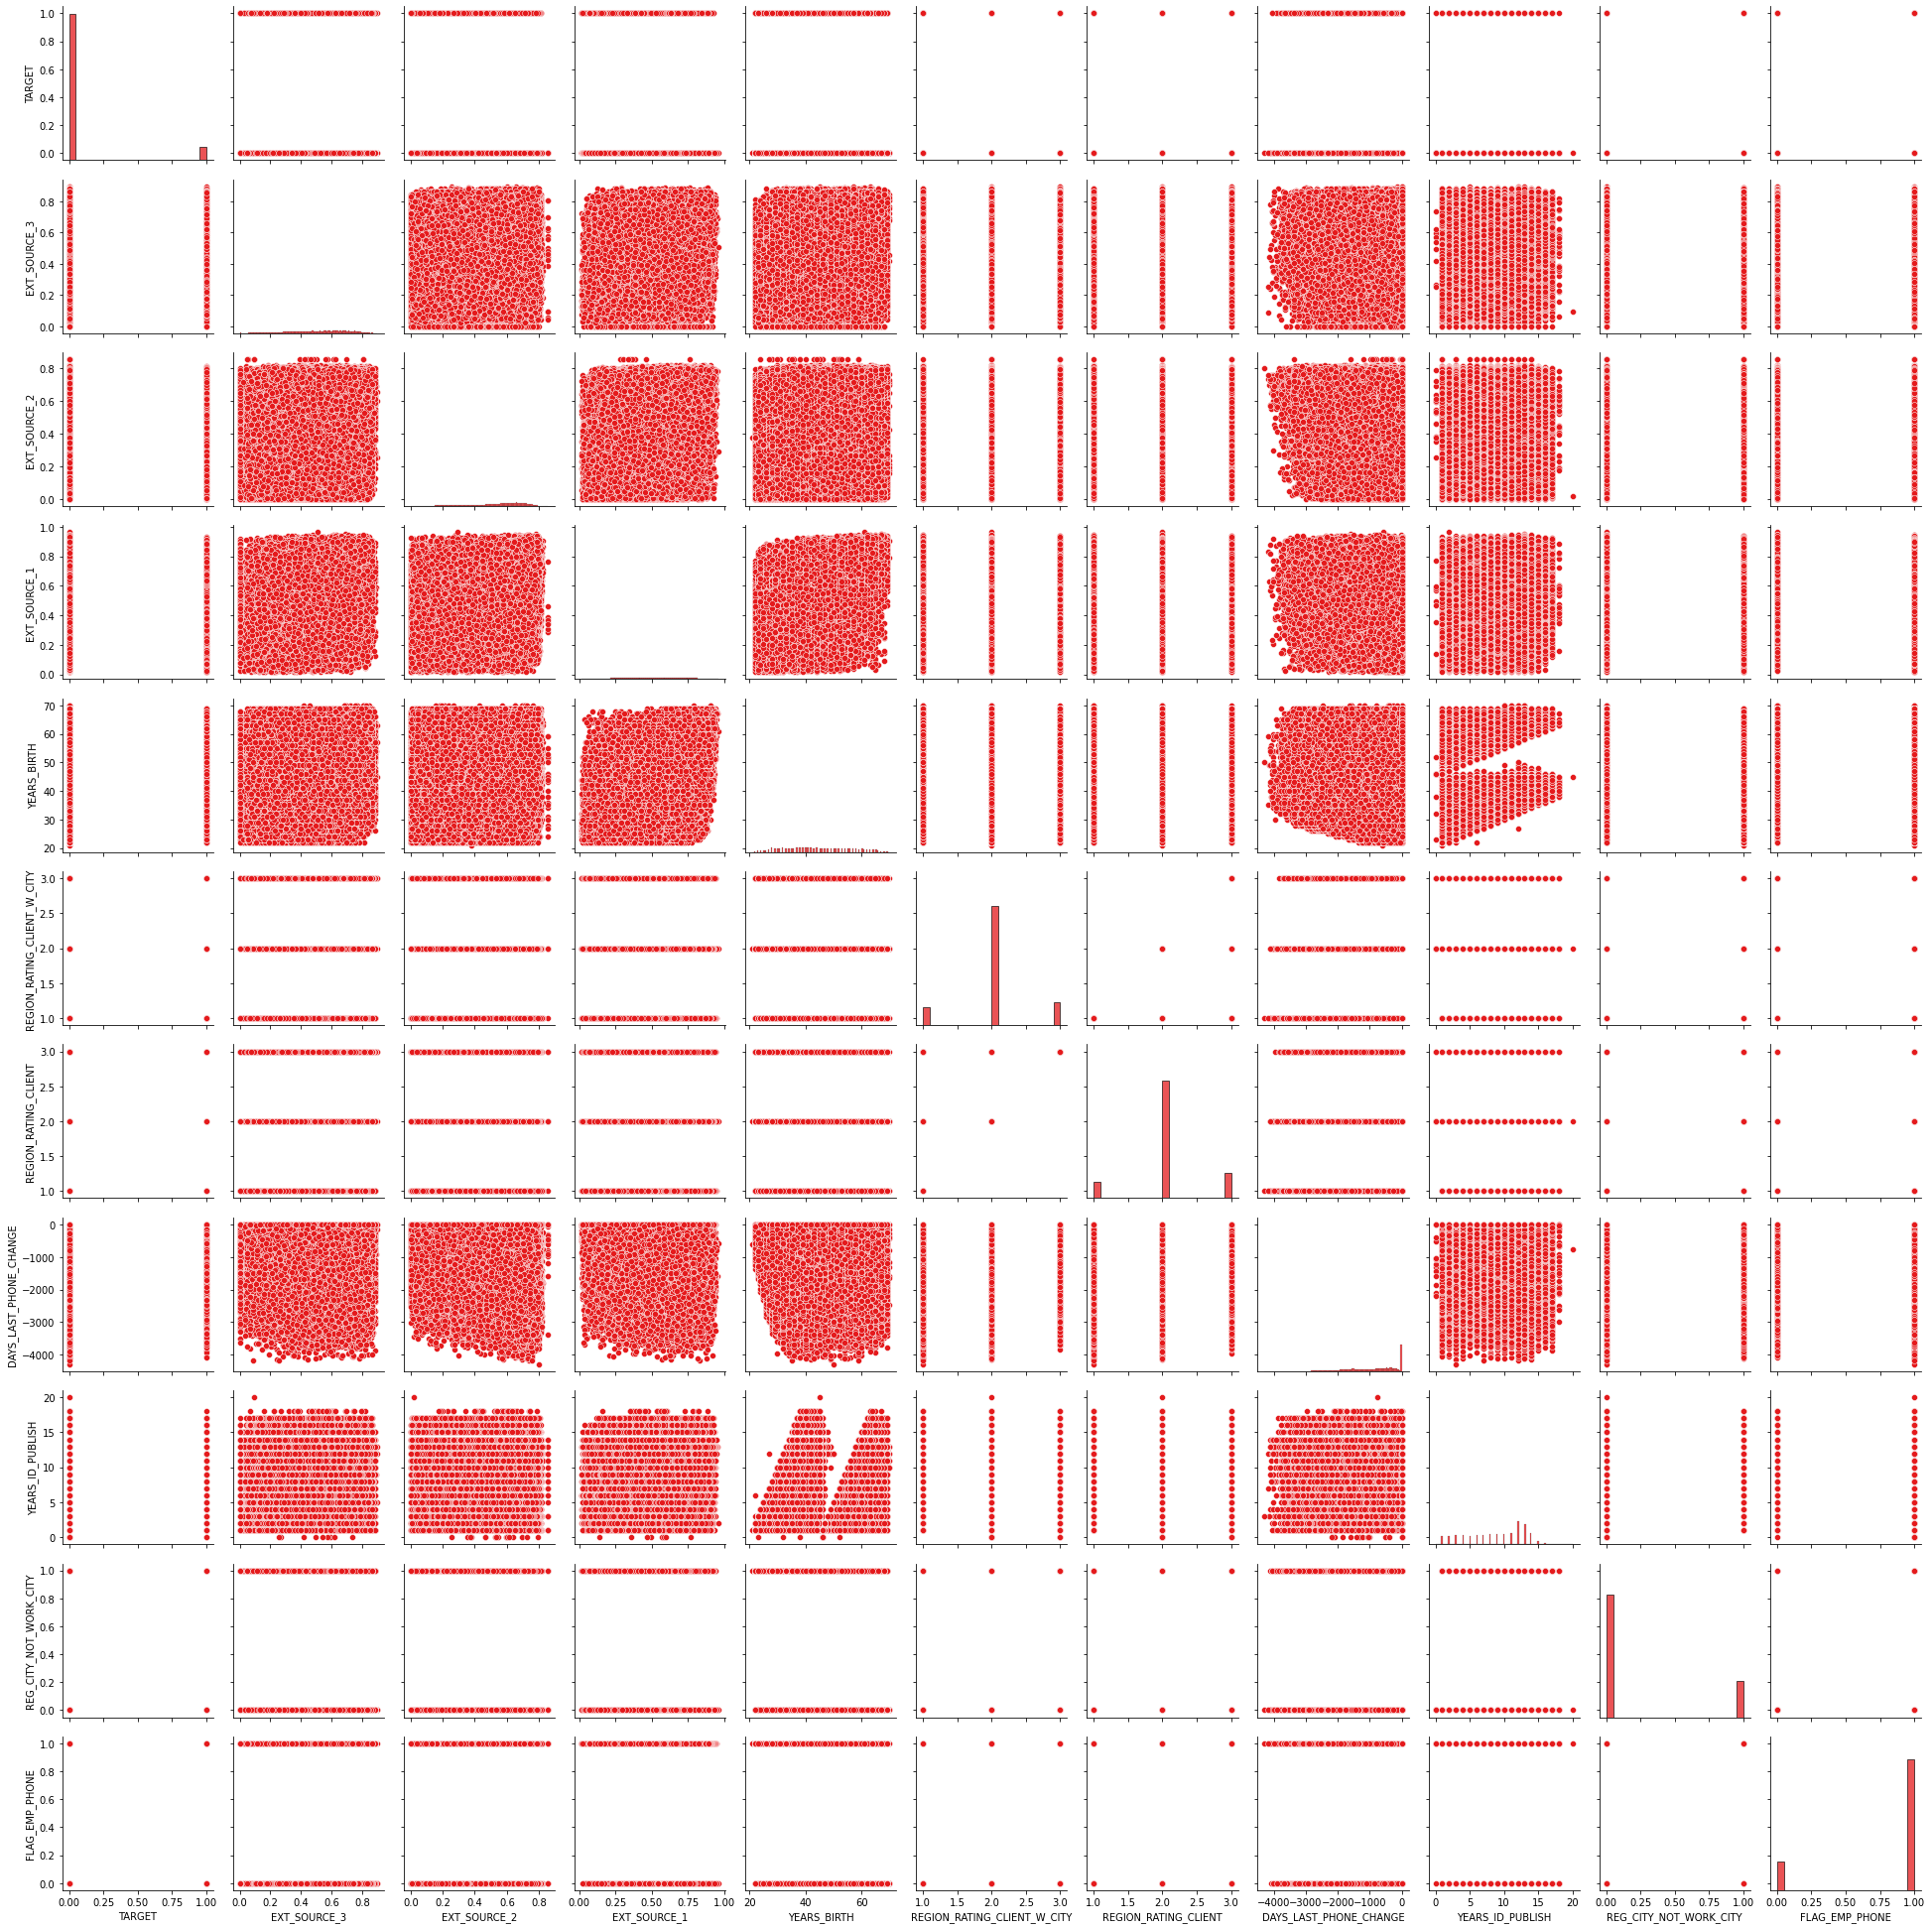

In [37]:
sns.pairplot(train_df_numeric[cols], height = 2.5)

Text(0.5, 0.98, 'Distribution of the categorical features')

<Figure size 1440x1080 with 0 Axes>

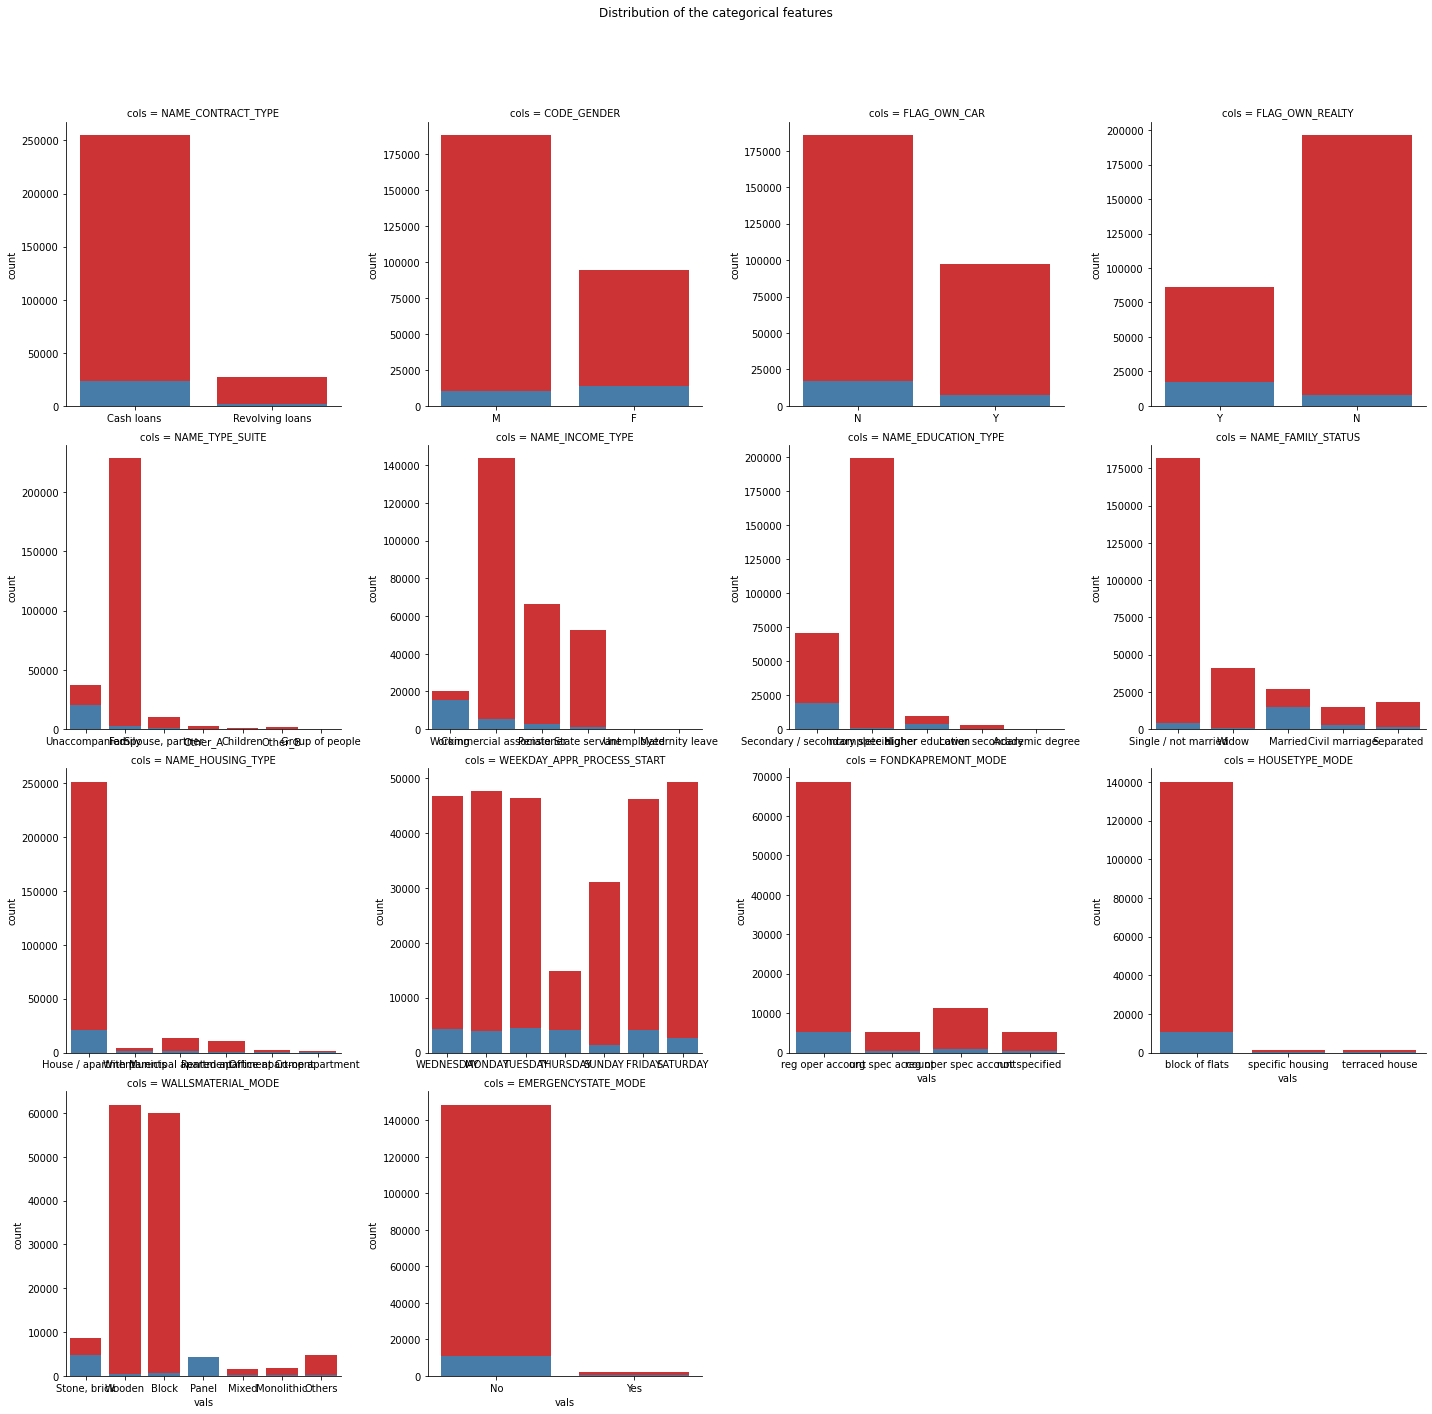

In [40]:
cat_df= train_df_cat.copy()
cat_df= cat_df.join(train_df_numeric['TARGET'])
cat_df.drop(['OCCUPATION_TYPE', 'ORGANIZATION_TYPE'], axis=1, inplace= True)
fig = plt.figure(figsize=(20, 15))
r = cat_df.melt(['TARGET'], var_name='cols',  value_name='vals')
g = sns.FacetGrid(r, col='cols', col_wrap=4, sharex=False, sharey=False, hue= 'TARGET', legend_out=False, height=5);
g = (g.map(sns.countplot, "vals"));
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution of the categorical features')

There are more male clients than female, however, more of the defaulters were female. Most of the clients didnt own a house and tookout cash loans

## **Summary of Observations**

* The dataset contains a lot of missing values. Majority of these missing values are concentrated in the apartment-based features which suggests that there is no information on where some of the clients lived. Hence these were inputed with zero.

* The target variable has two distinct classes. Most of the clients (91.9%) repaid their loans while 8.1% were defaulters. This implies that the target variable is imbalanced, which requires a proper crossvalidation strategy for good model evaluation.

* The distribution of income earned by the clients is skewed, which is not surprising, as well as the credit amount of the loan and loan annuity.

* The age of client is normally distributed, with a typical client being 44 years old on the average.

* Most of the defaulters had no children, did not provide work phone, or email address and could not be reached on their mobile phones.

* There are more male clients than female, however, more of the defaulters were female. Most of the clients didnt own a house and tookout cash loans.

